In [104]:
import spacy
import torch
import pandas as pd
import matplotlib.pyplot as plt
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

import seaborn as sns

#xgboost
from xgboost import XGBClassifier

#imblearn
from imblearn.over_sampling import SMOTE

# NFL Team Sentiment Analysis

The goal of this notebook is to make a sentiment analysis model which is able to identify sentiments of specific NFL teams, the idea is to use this prediciton model for specific NFL teams based on twitter/x posts and the community sentiment around these posts.

In [105]:
df = pd.read_csv('./nfl_get_sentiments/all_sentiments.csv')

In [106]:
df.head(10)

,username,timestamp,text,team,sentiment,sentiment_score,context_sentiment,context_modifiers,vader_scores,emoji_sentiment
0,KatWhitman,2024-11-09T23:54:55.000Z,By now Kansas City Chiefs tight end Travis Kel...,Kansas City Chiefs,negative,-0.17760,0.0,{},"{'neg': 0.109, 'neu': 0.842, 'pos': 0.049, 'co...",0
1,Kansas City Chiefs,2024-11-09T23:31:00.000Z,As we honor members of our troops during Salut...,Kansas City Chiefs,positive,0.29634,0.0,{},"{'neg': 0.0, 'neu': 0.931, 'pos': 0.069, 'comp...",0
2,Fantasy Forecasts,2024-11-09T23:41:05.000Z,Weather Warning Denver Broncos @ Kansas City C...,Kansas City Chiefs,neutral,0.04632,0.0,{},"{'neg': 0.086, 'neu': 0.822, 'pos': 0.092, 'co...",0
3,"Ryan Tracy - Consultant, Content Creator",2024-11-09T21:32:04.000Z,For the Kansas City Chiefs The Bucs are REAL b...,Kansas City Chiefs,positive,0.41646,0.0,{},"{'neg': 0.044, 'neu': 0.828, 'pos': 0.128, 'co...",0
4,Ryan,2024-11-09T21:31:54.000Z,The Kansas City Chiefs have an 11-7-2 record a...,Kansas City Chiefs,positive,0.12138,0.0,{},"{'neg': 0.0, 'neu': 0.917, 'pos': 0.083, 'comp...",0
5,"Ryan Tracy - Consultant, Content Creator",2024-11-09T21:28:16.000Z,Kansas City Chiefs rocked it! The NFL FAILED! ...,Kansas City Chiefs,positive,0.54294,0.3,{'outcome': 'win'},"{'neg': 0.088, 'neu': 0.716, 'pos': 0.196, 'co...",0
6,Fantasy Volcano,2024-11-09T21:15:00.000Z,Week 10 Fantasy Volcano Projections: Kansas Ci...,Kansas City Chiefs,positive,0.26424,0.0,{},"{'neg': 0.0, 'neu': 0.929, 'pos': 0.071, 'comp...",0
7,Spot The Win,2024-11-09T21:07:02.000Z,Denver Broncos @ Kansas City Chiefs The Bronco...,Kansas City Chiefs,negative,-0.38214,0.0,{},"{'neg': 0.104, 'neu': 0.896, 'pos': 0.0, 'comp...",0
8,Kansas City Chiefs Peeps,2024-11-09T21:07:01.000Z,AFC Notes: DeAndre Hopkins Courtland Sutton Jo...,Kansas City Chiefs,neutral,0.00000,0.0,{},"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0
9,Kansas City Chiefs,2024-11-09T21:00:01.000Z,Is it Sunday yet?,Kansas City Chiefs,neutral,0.00000,0.0,{},"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0


In [107]:
print(df['sentiment'].value_counts())
print(len(df))

sentiment
neutral     450
positive    448
negative    299
Name: count, dtype: int64
1197


In [108]:
# example text to do some cleaning
print(df['text'][10])

The Kansas City Chiefs remain undefeated in 2024 with a thrilling 30-24 victory over the Buccaneers on Monday Night Football. It's PRIMETIME at ARROWHEAD!


In [109]:
def clean_text(text):
    """
    Clean the text, convert to lowercase. remove urls, remove mentions, special characters
    and remove unnecessary whitespace
    """
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = ' '.join(text.split())
    
    return text

# apply to df    
df['cleaned_text'] = df['text'].apply(clean_text)
print(df[['text', 'cleaned_text']].head(2))

                                                text  \
0  By now Kansas City Chiefs tight end Travis Kel...   
1  As we honor members of our troops during Salut...   

                                        cleaned_text  
0  by now kansas city chiefs tight end travis kel...  
1  as we honor members of our troops during salut...  


In [110]:
nlp = spacy.load('en_core_web_lg')

def preprocess_text(text):
    """
    use spacy to convert to doc tokenize and lemmatize.
    """
    doc = nlp(text.lower())
    
    tokens = [token.lemma_ for token in doc
              if token.is_alpha
              and not token.is_stop
              and not token.is_space]
    
    return ' '.join(tokens)

df['cleaned_text'] = df['cleaned_text'].apply(preprocess_text)
print(df[['text', 'cleaned_text']].head(2))

                                                text  \
0  By now Kansas City Chiefs tight end Travis Kel...   
1  As we honor members of our troops during Salut...   

                                        cleaned_text  
0  kansas city chief tight end travis kelce likel...  
1  honor member troop salute service month chief ...  


In [111]:
df['sentiment'] = df['sentiment'].map({ 'negative': 0, 'neutral': 1, 'positive': 2})

([<matplotlib.axis.XTick at 0x19868d0b800>,
 [Text(0, 0, 'Negative'), Text(1, 0, 'Neutral'), Text(2, 0, 'Positive')])

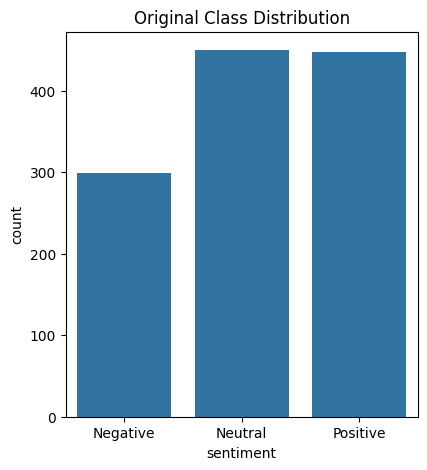

In [112]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.countplot(data=df, x='sentiment')
plt.title('Original Class Distribution')
plt.xticks([0, 1, 2], ['Negative', 'Neutral', 'Positive'])

In [113]:
X = df['cleaned_text']
y = df['sentiment']

In [114]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=7, stratify=y, test_size=0.2)

In [115]:
svc_params = {
    'feature_union__tfidf__max_features': [3000],
    'feature_union__tfidf__ngram_range': [(1,1)],
    'feature_union__tfidf__min_df': [2],
    'feature_union__tfidf__max_df': [0.9],
    'classifier__C': [20.0, 30.0, 40.0],
    'classifier__kernel': ['rbf'],
    'classifier__gamma': ['scale']
}

In [116]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# Try each model and compare results
def evaluate_model(model, params, X_train, X_test, y_train, y_test):
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    clf = GridSearchCV(
        model,
        params,
        cv=cv,
        scoring='f1_weighted',
        n_jobs=1,
        verbose=1
    )
    
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
    print(f"\nBest Score: {clf.best_score_}")
    print(f"Best Parameters: {clf.best_params_}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    return clf

In [117]:
from utils import (SPORTS_STOPWORDS, TEAM_NAMES, SPORTS_EMOJI_SENTIMENT,
                  GAME_OUTCOMES, PERFORMANCE_TERMS, STREAK_PATTERNS,
                  SEASON_CONTEXT)
import re
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.sparse import hstack

def extract_nfl_features(text):
    """Extract NFL-specific features from text using utils patterns"""
    features = {
        # Team mentions
        'team_mentions': 0,
        
        # Game outcomes
        'outcome_positive': 0,
        'outcome_negative': 0,
        
        # Performance sentiment
        'performance_positive': 0,
        'performance_negative': 0,
        
        # Season context
        'season_positive': 0,
        'season_negative': 0,
        
        # Emoji sentiment
        'emoji_sentiment': 0,
        
        # Streak mentions
        'winning_streak': 0,
        'losing_streak': 0,
        'undefeated': 0,
        'winless': 0
    }
    
    text_lower = text.lower()
    
    # Count team mentions
    for team_variant in TEAM_NAMES.keys():
        if team_variant in text_lower:
            features['team_mentions'] += 1
    
    # Check game outcomes
    for outcome, data in GAME_OUTCOMES.items():
        if re.search(data['pattern'], text_lower):
            key = 'outcome_positive' if outcome == 'win' else 'outcome_negative'
            features[key] += 1
            
    # Check performance terms
    for term, score in PERFORMANCE_TERMS['positive'].items():
        if term in text_lower:
            features['performance_positive'] += score
    for term, score in PERFORMANCE_TERMS['negative'].items():
        if term in text_lower:
            features['performance_negative'] += score
            
    # Check season context
    for term, score in SEASON_CONTEXT['positive'].items():
        if term in text_lower:
            features['season_positive'] += score
    for term, score in SEASON_CONTEXT['negative'].items():
        if term in text_lower:
            features['season_negative'] += score
            
    # Calculate emoji sentiment
    for emoji, score in SPORTS_EMOJI_SENTIMENT.items():
        if emoji in text:
            features['emoji_sentiment'] += score
            
    # Check streak patterns
    for pattern_name, pattern in STREAK_PATTERNS.items():
        if re.search(pattern, text_lower):
            features[pattern_name] = 1
            
    return features

In [118]:
from sklearn.pipeline import FeatureUnion
import numpy as np

class NFLFeatureUnion(FeatureUnion):
    def fit_transform(self, X, y=None, **fit_params):
        # Transform X into the expected format for each transformer
        transformed_features = []
        for name, transformer in self.transformer_list:
            transformed = transformer.fit_transform(X, y)
            if hasattr(transformed, 'toarray'):
                transformed = transformed.toarray()
            transformed_features.append(transformed)
        
        # Combine all features
        return np.hstack(transformed_features)
    
    def transform(self, X):
        # Transform X into the expected format for each transformer
        transformed_features = []
        for name, transformer in self.transformer_list:
            transformed = transformer.transform(X)
            if hasattr(transformed, 'toarray'):
                transformed = transformed.toarray()
            transformed_features.append(transformed)
            
        # Combine all features
        return np.hstack(transformed_features)

In [134]:
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import VarianceThreshold
from sklearn.pipeline import FunctionTransformer

# Create enhanced pipeline
nfl_pipeline = ImbPipeline([
    ('feature_union', NFLFeatureUnion([
        ('nfl_features', Pipeline([
            ('to_list', FunctionTransformer(lambda x: x.tolist())),
            ('extract', FunctionTransformer(lambda x: pd.DataFrame([extract_nfl_features(text) for text in x])))
        ])),
        ('tfidf', TfidfVectorizer(
            max_features=3000,
            ngram_range=(1, 1), 
            min_df=2,
            max_df=0.9,
        ))
    ])),
    ('scaler', StandardScaler(with_mean=False)),
    ('smote', SMOTE(random_state=42)),
    ('classifier', SVC(
        probability=True,
        class_weight={0: 2, 1: 2, 2: 1},
        gamma='scale',
        C=20,
        kernel='rbf'
    ))
])

In [135]:
# Fit the pipeline
nfl_pipeline.fit(X_train, y_train)

Pipeline(steps=[('feature_union',
                 NFLFeatureUnion(transformer_list=[('nfl_features',
                                                    Pipeline(steps=[('to_list',
                                                                     FunctionTransformer(func=<function <lambda> at 0x0000019865FC25C0>)),
                                                                    ('extract',
                                                                     FunctionTransformer(func=<function <lambda> at 0x0000019865FC28E0>))])),
                                                   ('tfidf',
                                                    TfidfVectorizer(max_df=0.9,
                                                                    max_features=3000,
                                                                    min_df=2))])),
                ('scaler', StandardScaler(with_mean=False)),
                ('smote', SMOTE(random_state=42)),
                ('classifier',
                 SVC(C=20, class_weight={0: 2, 1: 2, 2: 1}, probability=True))])

In [136]:
print("Training SVC...")
svc_model = evaluate_model(nfl_pipeline, svc_params, X_train, X_test, y_train, y_test)

Training SVC...
Fitting 5 folds for each of 3 candidates, totalling 15 fits

Best Score: 0.5629089042542087
Best Parameters: {'classifier__C': 20.0, 'classifier__gamma': 'scale', 'classifier__kernel': 'rbf', 'feature_union__tfidf__max_df': 0.9, 'feature_union__tfidf__max_features': 3000, 'feature_union__tfidf__min_df': 2, 'feature_union__tfidf__ngram_range': (1, 1)}

Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.30      0.38        60
           1       0.62      0.62      0.62        90
           2       0.60      0.77      0.67        90

    accuracy                           0.60       240
   macro avg       0.58      0.56      0.56       240
weighted avg       0.59      0.60      0.58       240



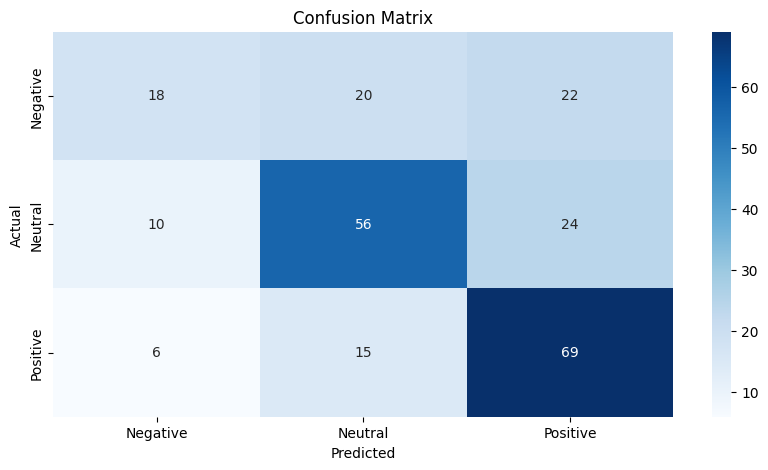

In [137]:
# Make predictions on test set
y_pred = nfl_pipeline.predict(X_test)

plt.figure(figsize=(10, 5))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [140]:
# Get predictions and actual values
y_pred = nfl_pipeline.predict(X_test)

print("Comparing predictions:")
for idx in range(10):  # Show first 10 examples
    tweet = X_test.iloc[idx]
    actual = y_test.iloc[idx]
    pred = y_pred[idx]
    
    actual_label = "Negative" if actual == 0 else "Neutral" if actual == 1 else "Positive"
    pred_label = "Negative" if pred == 0 else "Neutral" if pred == 1 else "Positive"
    
    print(f"\nTweet text: {tweet}")
    print(f"Actual: {actual_label}")
    print(f"Predicted: {pred_label}")


Comparing predictions:

Tweet text: wr darius slayton concussion trip germany new york giant week rule sunday game vs carolina
Actual: Neutral
Predicted: Negative

Tweet text: disaster year dallas cowboy go injury pile office terrible literally add insult injury
Actual: Negative
Predicted: Negative

Tweet text: new york giants carolina panther close nfl international series game munich sunday commissioner roger goodell say nfl work add game berlin
Actual: Neutral
Predicted: Neutral

Tweet text: g funk s call
Actual: Neutral
Predicted: Negative

Tweet text: icymi w dan continue giant struggle gerrit cole bronx take call listen
Actual: Negative
Predicted: Negative

Tweet text: new york giants fan not happy st round pick start tomorrow game right tackle natural position
Actual: Negative
Predicted: Positive

Tweet text: time preview week giant jet plus met set meeting juan soto
Actual: Neutral
Predicted: Neutral

Tweet text: panther name bryce young starting qb sunday game germany vs new y

In [138]:
import numpy as np

def predict_with_threshold(model, X, thresholds=[0.4, 0.4, 0.3]):
    """
    Custom prediction function with different thresholds for each class
    Args:
        model: Fitted pipeline
        X: Input features
        thresholds: List of thresholds for classes [0, 1, 2]
    """
    # Get probability predictions
    proba = model.predict_proba(X)
    
    # Initialize predictions array
    predictions = np.zeros(len(X))
    
    # Apply thresholds for each class
    for i in range(len(proba)):
        # Get class with highest probability
        max_class = np.argmax(proba[i])
        
        # Check if probability exceeds threshold for predicted class
        if proba[i][max_class] >= thresholds[max_class]:
            predictions[i] = max_class
        else:
            # If below threshold, assign to class with next highest probability
            proba[i][max_class] = 0  # Zero out the max prob
            predictions[i] = np.argmax(proba[i])  # Get next highest
    
    return predictions

# Use it after fitting your model
y_pred = predict_with_threshold(nfl_pipeline, X_test, thresholds=[0.4, 0.3, 0.3])
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.67      0.30      0.41        60
           1       0.61      0.66      0.63        90
           2       0.60      0.78      0.68        90

    accuracy                           0.61       240
   macro avg       0.63      0.58      0.57       240
weighted avg       0.62      0.61      0.59       240



In [97]:
test_tweets = [
    "Love watching the Colts play! Great team!",
    "Terrible game today, very disappointed, worst game i've seen in a while",
    "Just another regular game from the Colts"
]